<h1><span style="background-color:blue; color:white; padding: 5px;">Entrainment de modèles avec RandomForest Regressor<br></h1>
</h4><span style="background-color:red; color:white; padding: 5px;">Utiliser un outil permettant de rafraîchir la page régulièrement pour éviter la mise en sommeil de MLflow sur Heroku
</span></h4>

In [1]:
import pandas as pd
from functions2 import *

2024-02-16 19:42:08.516206: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 19:42:08.625419: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 19:42:08.627118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 19:42:09.972106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h2><span style="background-color:grey; color:white; padding: 5px;">Choix des paramètres pour l'entraînement, le stockage sur MLflow et des données à récupérer.</span></h2>

In [2]:
#//////////////////////////////////////////////////////////////////////////////
#                       Option de filtrage des données
#//////////////////////////////////////////////////////////////////////////////
# Variable permettant de choisir si on veut traiter les outliers
gestion_outliers =True

# Nombre de ventes minimum sur une commune pour calculer un prix moyen au m² par commune
nb_ventes_mini = 10

# Taux de filtrage : 
# - Le premier élément est le nombre de vente minimum par commune
# - Le deuxième élément est le pourcentage de outliers dans une commune
#
# Exemple pour tx_filtrage =[10,30] les lignes qui seront conservées seront :
# Les communes dans lesquelles il restera minimum 10 ventes après suppression des outliers
# ET  moins de 30% d'outliers
# ET les lignes inférieures à la limite des outliers
# tx_filtrage = [0,100] => Suppression des lignes dont le montant est au dessus de la limite des outliers.
tx_filtrage =[nb_ventes_mini,30]

# Recherche sur une région spécifique si recherche sur toute la France mettre ''
region=''

# Recherche sur un type de bien spécifique si recherche sur tous les bien mettre ''
type_de_bien ='Appartement'

# Inclure la surface du terrain True ou False
surface_terrain = False

# Nombre de mois pour l'entraînement et le test (train=80% test= 20%)
# Exemple si 15 mois environ 12 mois pour l'entraînement et 3 mois pour le test
# Mettre None pour utiliser toutes les données disponible
nb_mois=15

#//////////////////////////////////////////////////////////////////////////////
#                       Configuration du modèle
#//////////////////////////////////////////////////////////////////////////////
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2]
    }   
cv=5

#//////////////////////////////////////////////////////////////////////////////
#                       Configuration de mlfow
#//////////////////////////////////////////////////////////////////////////////
# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor"

# runs à effectuer all_datas 15months all_datas_surface_terrain 15months_surface_terrain)
run_name = f"{region}_{type_de_bien}_15months_GridSearch_no_outliers"
model_name = f"RFR_{run_name}"

<h2><span style="background-color:grey; color:white; padding: 5px;">Création de la requête </span></h2>

In [3]:
where_clause, query = construcion_requete(region,
                        type_de_bien,
                        nb_ventes_mini,
                        surface_terrain,
                        nb_mois)
print(query)


    # Table pour compter le nombre de ventes par commune
    WITH nb_ventes_mini AS(
    SELECT
        ID_COMMUNE AS ID_COMMUNE,
        count(*) nb_ventes_par_commune
    FROM VENTES 
    WHERE DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    GROUP BY ID_COMMUNE
    )

    # Selection des variables voulues pour l'entraînement du modèle
    SELECT 
        V.SURFACE_BATI,
        V.ID_COMMUNE,
        V.DATE_MUTATION,
        
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE R.Name_region NOT IN('Martinique', 'Guyane', 'La Réunion', 'Mayotte', 'Guadeloupe') AND T.NAME_TYPE_BIEN='Appartement' AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    AND V.MONTANT>15000  AND V

<h2><span style="background-color:grey; color:white; padding: 5px;">Chargement des données et suppression des outliers. </span></h2>

In [4]:
where_clause, query = construcion_requete(region,
                                          type_de_bien,
                                          nb_ventes_mini,
                                          surface_terrain,
                                          nb_mois)

df = loading_data(query)

if gestion_outliers==True:
    df=filtrage(df,tx_filtrage,where_clause)

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Il y a 8769 communes avec plus de 10 ventes avant suppression des outliers, pour un total de 492005 ventes
Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok


,ID_COMMUNE,nb_outliers,total_ventes,ventes_restantes,NAME_COMMUNE,pourcentage_ventes_retirees
0,06088,1400,11427,10027,Nice,12.25
1,92012,1277,2461,1184,Boulogne-Billancourt,51.89
2,92051,1098,1397,299,Neuilly-sur-Seine,78.60
3,06029,930,3984,3054,Cannes,23.34
4,92044,837,1527,690,Levallois-Perret,54.81
5,33063,724,5455,4731,Bordeaux,13.27
6,78646,642,1326,684,Versailles,48.42
7,94080,575,1157,582,Vincennes,49.70
8,92026,527,1496,969,Courbevoie,35.23
9,92004,519,1749,1230,Asnières-sur-Seine,29.67


Nombre d'outliers : 31407
Nombre de commune avec des outliers : 1829
Nombre de communes contenant des outliers et pour lesquels ilreste plus de 10 ventes après suppression des outliers : 1402
Nombre de communes avec plus de 30% de ventes retirées : 302
Nombre de communes qui seront retirées : 482
Nombre de ventes restantes après suppression des outlier et après filtrage : 446322
Il y a donc eu 9.29% de lignes supprimées après filtrage


<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement du modèle et stockage des données avec MLflow. </span></h2>

Split des données en cours...


/home/kevin/workspace/PCO/certif_app_immo/model/functions2.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['M2'] = df_train['MONTANT'] / df_train['SURFACE_BATI']


Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  14.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  14.8s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  15.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  15.2s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  13.7s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_mae,split1_test_mae,...,std_test_mae,rank_test_mae,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,14.598349,0.712419,0.293697,0.027294,10,2,50,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",-40793.068886,-40536.690983,...,2283.562022,1,0.570741,0.596665,0.66051,0.647308,0.66194,0.627433,0.036988,1


Ré-entraînement avec les meilleurs hyperparamètres en cours...


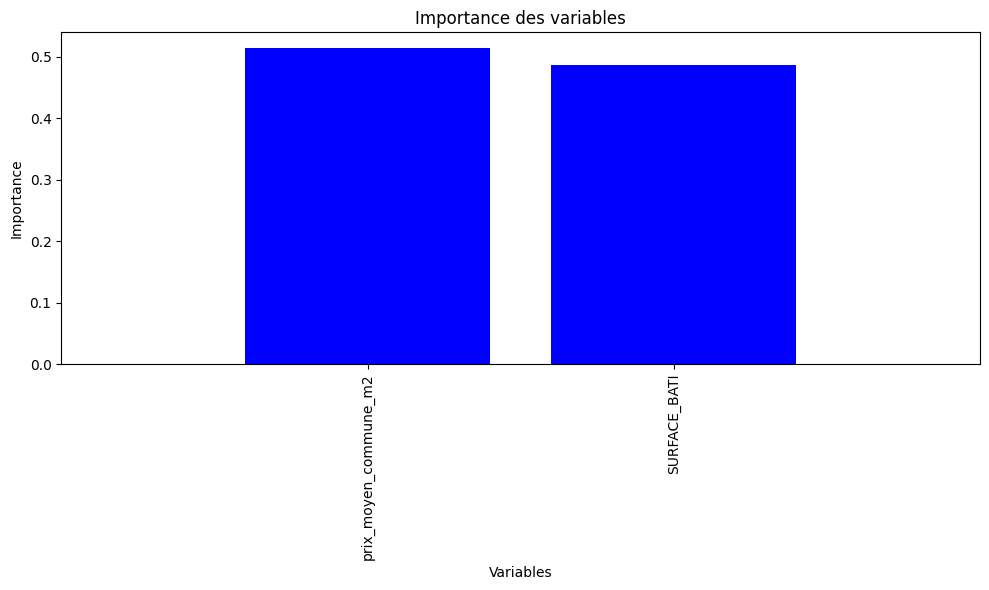

/home/kevin/workspace/PCO/certif_app_immo/model/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/kevin/workspace/PCO/certif_app_immo/model/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


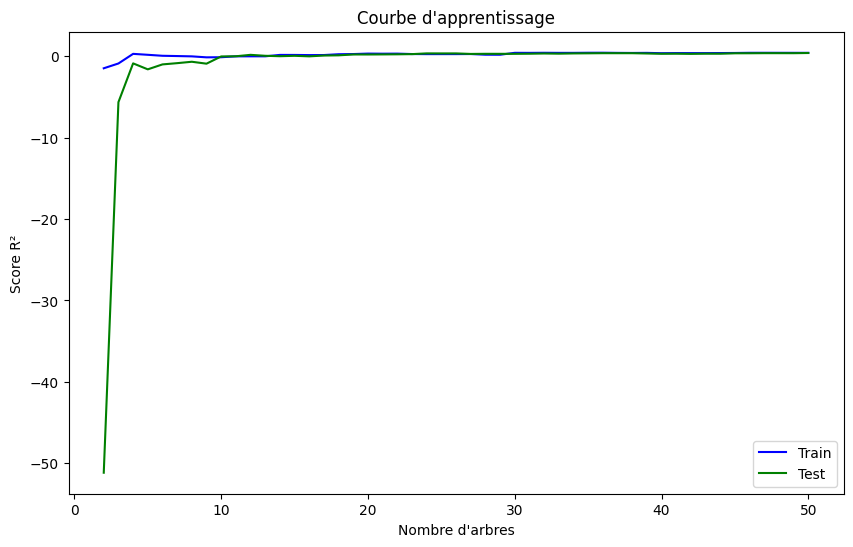

Entraînement OK
Tracé du graphique en cours...
Itération N°1 : train score = 0.702577269271217 -- validation score = 0.6289636129584129
Itération N°2 : train score = 0.6786786462136505 -- validation score = 0.6352330216502828
Itération N°3 : train score = 0.6704989193965818 -- validation score = 0.6380411859123442
Itération N°4 : train score = 0.6631926590427264 -- validation score = 0.639215233072632
Itération N°5 : train score = 0.6589730552421476 -- validation score = 0.640312753222456
Itération N°6 : train score = 0.655081971119043 -- validation score = 0.6410344674470104
Itération N°7 : train score = 0.6530394571461149 -- validation score = 0.6413461736189465
Itération N°8 : train score = 0.6514466834054056 -- validation score = 0.6417100264628601
Itération N°9 : train score = 0.6510524674779075 -- validation score = 0.6421949358213478
Itération N°10 : train score = 0.6504334908915967 -- validation score = 0.6423126134407642


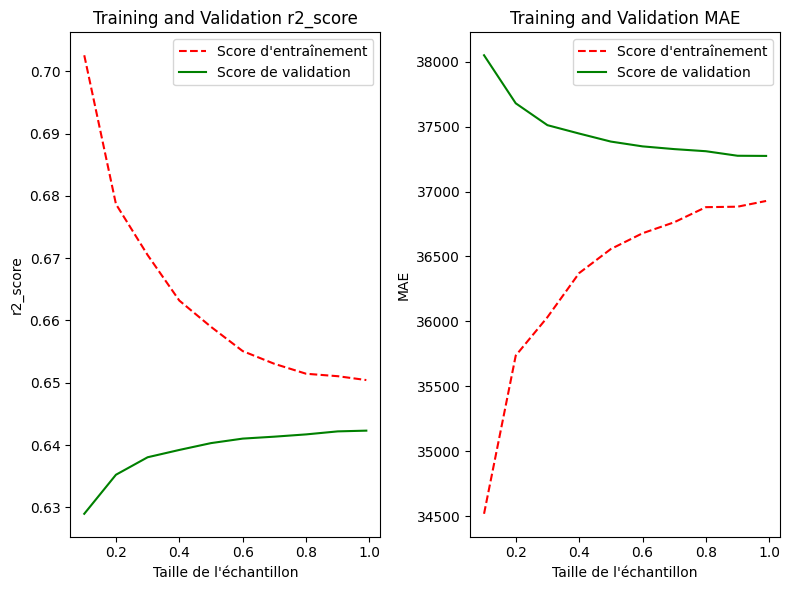

Log du modèle et des artifacts en cours...


Successfully registered model 'RFR__Appartement_15months_GridSearch_no_outliers'.
2024/02/16 19:53:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFR__Appartement_15months_GridSearch_no_outliers, version 1
Created version '1' of model 'RFR__Appartement_15months_GridSearch_no_outliers'.


In [5]:
X_train,y_train, X_test, y_test = split_with_m2(df)

X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

model, best_params, features_importances, learning_curve = train_model_randomforest(X_train,y_train,X_test,y_test, param_grid, cv)

# Tracé et enregistrement du graphique permettant de savoir si le modèle contient suffisamment de données.
validation_curve = plot_validation_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)

param_mlflow(uri_tracking=uri_tracking,
        experiment_name=experiment_name, run_name=run_name,
        best_params=best_params,
        model=model, model_name=model_name,
        X_test=X_test, y_test=y_test,
        encoders=encoders,scalers=scalers,
        images = [validation_curve, features_importances, learning_curve]).log_mlflow()